#### Titanic Classification using genetic algorithms

In this notebook I will use TPOT library to automate the Machine Learning process of selecting the best algorithm and tuning it's hyper parameters.

One we cleaned our data and we are ready to fit the data to our classification algorithm, we can use TPOT to choose the best classifier with the highest accuracy.

Of course there are some requirement for TPOT to work effectively, that is we must ensure that our data is in numerical format , i.e all the categorical variables have been encoded correctly , either through label encoder or dummy variable columns.
but overall it's a fairly straight forward process , where you can automate ML models in a very few lines of codes.

Once we fit the data to TPOT , tpot actually generates a python code (your can export this to your chosen file) with Pipelines of the best algorithm to use with all the hyperparamters tuned to provide the highest accuracy.

I found out about TPOT after reading an articel about genetic algorithm , and how this could save so much time for data scientitsts and also increase the efficiency and accuracy of certain models.

I am very new the world of data science but I do love it and this is infact my first kernel, so if I have made any errors or if the code is not in it's optimal format I do appologise in advance.

any feedback, criticism and suggestion is highly welcomes and highly valued in my eyes.

* Let's Go ahead and import the libraries needed for this task

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


I am going to read the dataset from my drive and investigate the Null values right after reading it.
We need to make sure our data does not contain any Null values , and if it does , we need to deal with it accordingly.

In [3]:
titanic = pd.read_csv("train.csv")
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

As we can see above **Age**,**Cabin**, **Embarked** columns contain Null values ,I am going to deal with this by filling them with a values that is really out of range in order to make it easy for the model to recoginse as outliers.

In this case I chose **-999** to fill the Null values

In [4]:
titanic.fillna(-999,inplace = True)
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Again it's TPOT's requirement to rename the target column(the reponse column) with **class**, this is because TPOT uses the name "class" in it's codes to generate X , y matrices.

below I have renamd the target class which is the Survived column in this dataset with class

In [5]:
titanic.rename(columns = {"Survived":"class"},inplace = True)

Another one of TPOT's reuqirement is that all columns must be in numerical format, thus we need to encode the categoircal columns using an appropriate enocder method.

First let's have a look at our data types in the data set.

In [6]:
titanic.dtypes 

PassengerId      int64
class            int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

We can see that the columns [**Name** , **Sex**, **Ticket**, **Cabin**, **Embarked**] are categorical variables, so we need to encode them.

But first let's visualise the number of unique categories in each of these columns in order to help us choose the best method to enocde our categorical values.

I will be simply loop through these columns and print out the number of unique categorical values in each column.

In [7]:
for col in ["Name","Sex","Ticket","Cabin","Embarked"]:
    print((col , titanic[col].unique().size))

('Name', 891)
('Sex', 2)
('Ticket', 681)
('Cabin', 148)
('Embarked', 4)


As we can see above Sex and Embarked have small number unique categorical values, let's go ahead and see what they are.

In [10]:
titanic.Sex.unique()

array(['male', 'female'], dtype=object)

So in the Sex column we have males and females , well that's quite easy to solve , we just replace males with 1 and females with 0, or vice versa.

In [12]:
titanic.Embarked.unique()

array(['S', 'C', 'Q', -999], dtype=object)

So for the Embarked column we have three types of values with the Null values which we replaced with -999 in the earlier steps of this code.

again this is as straight forward as the Sex column , we will use 0 for S , 1 for C and 2 for Q.
althought we could use dummy variables in here using pandas pd.get_dummies() method , but because we only have three variables it's not really necessary, if we had more than three it would have been a better choice for this particular encoding problem.

to encode the column I used a map function with a defined dictionary as a parameter , the dictionary keys are the values I want to change and the dictionary values are the values I want to see as a result of the change.

In [13]:
titanic.Sex = titanic.Sex.map({"male":1,"female":0})
titanic.Embarked = titanic.Embarked.map({"S":0,"C":1,"Q":2})

titanic.fillna(-999,inplace = True)

I am not going to encode Name and ticket since I can't see them adding any particular value to the model, however I will encode the Cabin column, and this is not as straight forward as the Sex and embarked column since it has a mixture of integer and string in it's values , lucky for us scikit learn has just the right class for that known as **MultiLabelBinarizer** and this is in the preprocessing module.

So to use this class , we first import it , we intitialise it and the we fit it to our column Cabin values , note that the values need to be in a string format, so I use the str() method for each value in the column.
it's quite important to use curly bracket arround str() method to convert it into a **set** so make sure it's there.

A quick reminder:

Dictionary >>>>>  {key:Value}

Set >>>>>>>   {value}

and then transform the column.

or you can fit_transform to perform both of those steps at once , like I have below.

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
ml = MultiLabelBinarizer()
Cabin_trans = ml.fit_transform([{str(val)} for val in titanic.Cabin.values])


# This is just a quick test to make sure we pulled the right cabin values
assert(len(ml.classes_)==len(titanic.Cabin.unique())),"Not Equal"

No Error , so our code worked as we expected and the MultiLabelBinarizer pulled all the unique values and converted them.

We are ready to create our features matrix , and this will be the matrix of all features that will help the model predict unseen data, I will not be using Name and ticket in my model so I will drop them.
the class column will be the target column also known as the reponse vector. and we are going to add the transformed version of cabin values , therefore cabin can be removed too.

We will be left with 8 Column.

In [26]:
X = titanic.drop(["Cabin","class","Name","Ticket"],axis =1)
X.shape

(891, 8)

let's take a look at the transformed cabin before we add it to our X matrix

In [25]:
Cabin_trans.shape

(891, 148)

so we get 891 rows as we expected and now we have 148 columns to represet the Cabin feature encoded.
lets add these to the right of our X matrix and since the transferred cabin value is a numpy array , we can use Numpy Hrizontal stack method to do this, since we are going to add the array horizontally to the right.

In [27]:
X = np.hstack((X.values,Cabin_trans))

Now the 148 columns of cabin + our 8 column of X = 156 column which is exactly what we have as a number of columns for our new X

In [28]:
X.shape

(891, 156)

Let's define the reponse vector and call it **y**.

In [30]:
y = titanic["class"].values

lets take a look at the shape of the y, we can see it's a single column with 891 rows, i.e it's a vector of 891 rows.

In [31]:
y.shape

(891,)

Ok..we are ready to start building the model now , let's start by splitting our data into training and test sets

In [32]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.15, random_state = 0)

Once we have the clean data it's very easy to use the TPOT library, I have done so in three lines of code below.
an important note to point our in here is the **generations** parameter which is by default 100.
the idea in here is the more time you give TPOT the more of chance you have of a higher accuracy.
each added generation will take about five minutes , and based on the documentation the 100 generation will take up to 8 hours. that is of course given that you do not set **max_time_mins** which will over write the generation parameter and stop after the amount of minutes you give it.

below I have used 2 minutes as max_time_mins.

In [33]:
from tpot import TPOTClassifier
tpot_classifier = TPOTClassifier(generations=5,population_size=60,verbosity=2,max_time_mins=2)
tpot_classifier.fit(X, y)


C:\Users\Mostafa\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Generation 1 - Current best internal CV score: 0.8193564974943144


TPOT closed prematurely. Will use the current best pipeline.



Best pipeline: RandomForestClassifier(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=DEFAULT, PolynomialFeatures__interaction_only=DEFAULT), RandomForestClassifier__bootstrap=DEFAULT, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_features=0.4, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=18, RandomForestClassifier__n_estimators=DEFAULT)


TPOTClassifier(config_dict={'sklearn.naive_bayes.GaussianNB': {}, 'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.naive_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.tree.DecisionT....45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}}}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        generations=1000000, max_eval_time_mins=5, max_time_mins=2,
        mutation_rate=0.9, n_jobs=1, offspring_size=60, population_size=60,
        random_state=None, scoring=None, subsample=1.0, verbosity=2,
        warm_start=False)

As you can see in the message above it states "TPOT closed prematurely" this is due to the max_time_mins parameter we defined.

so it will choose the best model that it found within 2 minutes , which in this case is the RandomForestClassifier with polyniomial features.

let's take a look at the accuracy score of our test set using TPOT score method.


In [17]:
tpot_classifier.score(X_test,y_test)

0.90298507462686572

Now let's take a look at the code TPOT generated, im going to save the code in the file below.

In [34]:
tpot_classifier.export("TPOT_Genetic_Algorithm.py")

and open that file in the cell below

In [ ]:
# %load TPOT_Genetic_Algorithm.py
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# NOTE: Make sure that the class is labeled 'class' in the data file
tpot_data = np.recfromcsv('PATH/TO/DATA/FILE', delimiter='COLUMN_SEPARATOR', dtype=np.float64)
features = np.delete(tpot_data.view(np.float64).reshape(tpot_data.size, -1), tpot_data.dtype.names.index('class'), axis=1)
training_features, testing_features, training_target, testing_target = \
    train_test_split(features, tpot_data['class'], random_state=42)

exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2),
    RandomForestClassifier(criterion="entropy", max_features=0.4, min_samples_leaf=9, min_samples_split=18)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [39]:
# %load TPOT_Genetic_Algorithm.py
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# NOTE: Make sure that the class is labeled 'class' in the data file
# tpot_data = np.recfromcsv('PATH/TO/DATA/FILE', delimiter='COLUMN_SEPARATOR', dtype=np.float64)
# features = np.delete(tpot_data.view(np.float64).reshape(tpot_data.size, -1), tpot_data.dtype.names.index('class'), axis=1)
training_features, testing_features, training_target, testing_target = \
    train_test_split(X,y, random_state=42)

exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2),
    RandomForestClassifier(criterion="entropy", max_features=0.4, min_samples_leaf=9, min_samples_split=18)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [40]:
from sklearn.metrics import accuracy_score
score = accuracy_score(testing_target,results)
score

0.81165919282511212

In [41]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = exported_pipeline,X = training_features,y = training_target,scoring = "accuracy",
                            cv = 10)
print("The Accuracy {} ± {}".format(accuracies.mean(),accuracies.std()))

The Accuracy 0.8039508340649691 ± 0.053574928770839185


As we can see from the kfold accuracy and the confusion matrix accuracy above , we get good accuracy of 81% with a standard deviation of 5%, although this can be improved if you give TPOT a longer duration.

but over all this looks very good for 2 minutes!

Now we need to read our test data set and perform some data cleaning on the test set before can feed it to our model.
just like the training data we first need to deal with Null Values , first lets identify the null values

In [43]:
titanic_test = pd.read_csv("test.csv")
titanic_test.isnull().sum()


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We can see we have Null values for Age and Cabin, before I go ahead and fill the null values of the dataframe.
I want to deal with the cabin column first.

We used MultiLabelBinarizer to fit and transform our training set , which resulted in 148 columns to represent the Cabin column , now we may have new cabin values that were not in our training set and consequently not in out MultiLabelBinarizer model, so we should identify these new cabin values and treat them as Null values just to make sure we have the same number feautres columns in training and test sets.

to identify these new values, I am going to subtracts the set values of Cabin columns to leave only the new Cabin values.

In [44]:
new_cabin_value_from_test =list(set(titanic_test.Cabin)-set(titanic.Cabin))

And once we have those new cabin values we can use the "isin" method to compare the values of Cabin and if the value is in the new cabin values we will replace them with -999.

this is done such as below.

In [45]:
titanic_test.loc[titanic_test["Cabin"].isin(new_cabin_value_from_test),"Cabin"]=-999

Once the values of Cabin have been corrected we can transform using our MultiLabelBinarizer model that we initialised and fitted from our training dataset.

such as below

In [48]:
test_cabin = ml.transform([{str(val)} for val in titanic_test.Cabin.values])

Now that we are done with the Caibin values lets go ahead and create X test matrix by dropping the unnecessary columns

In [50]:
titanic_test = titanic_test.drop(["Name","Ticket","Cabin"],axis = 1)

Just like the training set we need to encode the Sex and the Embarked columns

In [49]:
titanic_test.Sex = titanic_test.Sex.map({"male":1,"female":0})

I won't be using the method below for this dataset , but I wanted to show what It would be if we used the pandas
get_dummies method.

As you can see Pandas created dummy variables and drops the first one as required, and we see these dummy variables at the far right of our data below.

In [51]:
pd.get_dummies(data = titanic_test,drop_first=True).head()

PassengerId  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_Q  \
0          892       3    1  34.5      0      0   7.8292           1   
1          893       3    0  47.0      1      0   7.0000           0   
2          894       2    1  62.0      0      0   9.6875           1   
3          895       3    1  27.0      0      0   8.6625           0   
4          896       3    0  22.0      1      1  12.2875           0   

   Embarked_S  
0           0  
1           1  
2           0  
3           1  
4           1

I wil be using the same method as I used in our training set, that is to use a map function to encode our embarked categories

In [57]:
titanic_test.Embarked = titanic_test.Embarked.map({"S":0,"C":1,"Q":2})

and finally replace the null values of the dataframe with -999

In [58]:
titanic_test.fillna(-999,inplace = True)

In [59]:
titanic_test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [60]:
titanic_test.tail()

PassengerId  Pclass  Sex    Age  SibSp  Parch      Fare  Embarked
413         1305       3    1 -999.0      0      0    8.0500         0
414         1306       1    0   39.0      0      0  108.9000         1
415         1307       3    1   38.5      0      0    7.2500         0
416         1308       3    1 -999.0      0      0    8.0500         0
417         1309       3    1 -999.0      1      1   22.3583         1

let's add the transform cabin values to our matrix of features and call it titanic_submission

In [70]:
titanic_submission = np.hstack((titanic_test.values,test_cabin))

And now we are ready to predict and classify the test results

In [71]:
submission = tpot_classifier.predict(titanic_submission)

Let's go ahead and create the submission file , (My first ever! )

In [133]:
Submission = pd.DataFrame({"PassengerID":titanic_submission[:,0].astype(int),"Survived":submission})

I don't like having three columns , so I'm just going to reset the index with the passengerID

In [134]:
Submission.set_index("PassengerID",inplace = True)

Save the result as a csv format in my drive!

In [135]:
Submission.to_csv("Submit_file_TPOT.csv")

Just before I end this notebook , let's take a look at the result, this is not a comparison to another model, just a simple visualistion of the survived passengers against the deceased.

In [76]:
Submission.head()

Submission
PassengerID            
892                   0
893                   0
894                   0
895                   0
896                   0

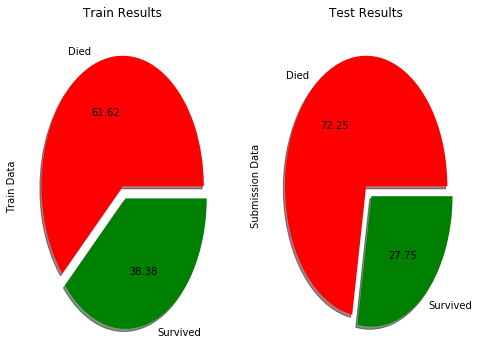

In [136]:

# Submission.Submission.value_counts().plot(autopct = "%.2f",
#                                           subplots = True ,
#                                           kind = "pie",
#                                           explode = [0,0.1],
#                                           colors = ["red","green"],
#                                           labels = ["Died","Survived"],
#                                           figsize = (4,4),
#                                          shadow = True)

# plt.title("Test Result")

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,2,1)
ax.pie(titanic["class"].value_counts(),colors = ["red","green"],autopct = "%.2f",explode = [0,0.1],
      labels = ["Died","Survived"],shadow = True
      )
ax.set_title("Train Results")
ax.set_ylabel("Train Data")


ax = fig.add_subplot(1,2,2)
ax.pie(Submission.Survived.value_counts(),colors = ["red","green"],autopct = "%.2f",explode = [0,0.1],
      labels = ["Died","Survived"],shadow = True
      )
ax.set_title("Test Results")
ax.set_ylabel("Submission Data")